<a href="https://colab.research.google.com/github/Real1CM/LLM_Z2H/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Total 552 (delta 0), reused 0 (delta 0), pack-reused 552 (from 1)
Receiving objects: 100% (552/552), 17.89 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [2]:
%cd "pytorch_advanced"
%cd "1_image_classification"

/content/pytorch_advanced
/content/pytorch_advanced/1_image_classification


In [3]:
import os
import urllib.request
import zipfile


data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)
    zip.close()

    os.remove(save_path)

In [4]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [9]:
# Be called in DataSet class
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([ # train
            transforms.RandomResizedCrop( # crop the photo
                resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(), # 50% flip the photo
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([ # validate
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img)

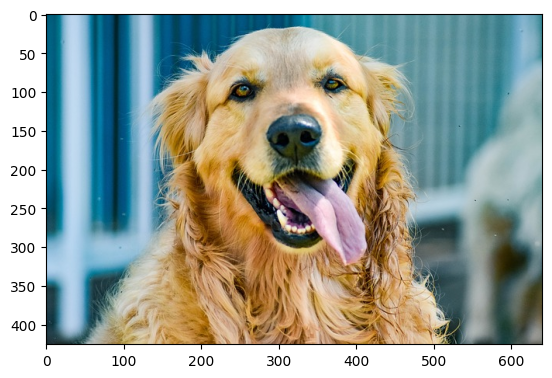

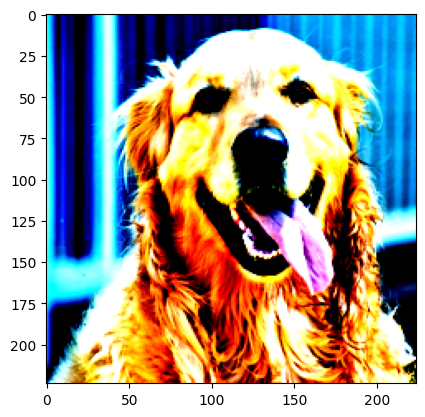

In [7]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [8]:
def make_datapath_list(phase="train"):
  rootpath = "./data/hymenoptera_data/"
  target_path = osp.join(rootpath+phase+'/**/*.jpg') # 路径拼接
  print(target_path)
  path_list = []

  for path in glob.glob(target_path): # 根据target_path路径查找路径
    path_list.append(path)

  return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")
train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/1799726602_8580867f71.jpg',
 './data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg',
 './data/hymenoptera_data/train/bees/2227611847_ec72d40403.jpg',
 './data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg',
 './data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg',
 './data/hymenoptera_data/train/bees/3074585407_9854eb3153.jpg',
 './data/hymenoptera_data/train/bees/2486746709_c43cec0e42.jpg',
 './data/hymenoptera_data/train/bees/522104315_5d3cb2758e.jpg',
 './data/hymenoptera_data/train/bees/2728759455_ce9bb8cd7a.jpg',
 './data/hymenoptera_data/train/bees/586041248_3032e277a9.jpg',
 './data/hymenoptera_data/train/bees/92663402_37f379e57a.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/2384149906_2cd8b0b699.jpg',
 './data/hymenoptera_data/train/bees/3090975720_71f12e6de4.jpg',
 './data/hymenoptera_data/train/bees/760568592_45a52c847f.jpg',
 './data/hymenoptera_data/train

In [10]:
#DataSet
class HymenopteraDataset(data.Dataset): #继承了Dataset基类
  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = self.file_list[index]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)

    if self.phase == "train":
      label = img_path[30:34]
    elif self.phase == "val":
      label = img_path[28:32]

    if label == "ants":
      label = 0
    elif label == "bees":
      label = 1

    return img_transformed, label

train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [11]:
batch_size = 32 # 一批32个
# DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"]) # 返回迭代器对象
inputs, labels = next(batch_iterator) #迭代器的第一个元素
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 1])
